In [1]:
import os
import glob
import cv2
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [2]:
# -------- CONFIGURATION ----------
DATA_DIR = "flowers"               
IMAGE_MAX_SIZE = 400           
VOCAB_SIZE = 100               
RANDOM_STATE = 42
TEST_SIZE = 0.2
KNN_NEIGHBORS = 5
BATCH_KMEANS = True
# ---------------------------------
mean_pools =[]
max_pools =[]
min_pools =[]
features = []
# ---------------------------------
image_descriptors = [] 
all_descriptors = []    

In [34]:
def load_images_and_labels(data_dir):
    images = []
    labels = []
    classes = sorted(os.listdir(data_dir))
    class_to_idx = {c: i for i, c in enumerate(classes)}
    for c in classes:
        files = glob.glob(os.path.join(data_dir, c, "*"))
        for f in files:
            img = cv2.imread(f)
            if img is None:
                continue
            # Resize to limit computation:
            h, w = img.shape[:2]
            scale = IMAGE_MAX_SIZE / max(h, w) if max(h, w) > IMAGE_MAX_SIZE else 1.0
            if scale != 1.0:
                img = cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
            images.append(img)
            labels.append(class_to_idx[c])
    return images, np.array(labels), classes

def preprocess_image(img, max_size=400):
    """Resize, grayscale, denoise, and enhance contrast for SIFT."""
    h, w = img.shape[:2]
    scale = max_size / max(h, w)
    if scale < 1.0:
        img = cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    return gray

def confusion_matrix_plot(y_true, y_pred, classes, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(np.arange(len(classes)), classes, rotation=90)
    plt.yticks(np.arange(len(classes)), classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def evaluate_model_plot_confusion_matrix(y_test, y_pred, classes, title_suffix=""):
    acc = accuracy_score(y_test, y_pred)
    print(f"KNN Accuracy {title_suffix}: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=classes))
    confusion_matrix_plot(y_test, y_pred, classes, title=f"Confusion Matrix {title_suffix}")


In [4]:
# 1) Load
images, labels, classes = load_images_and_labels(DATA_DIR)
print(f"Loaded {len(images)} images from {len(classes)} classes.")

Loaded 4317 images from 5 classes.


In [5]:
sift = cv2.SIFT_create() 
# 3) Extract descriptors for all images (BoVW)
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, desc = sift.detectAndCompute(gray, None)
    if desc is None:
        desc = np.zeros((0, 128), dtype=np.float32)
    image_descriptors.append(desc)
    if desc.shape[0] > 0:
        all_descriptors.append(desc)

if len(all_descriptors) == 0:
    raise RuntimeError("No descriptors found in any image.")
all_descriptors_stacked = np.vstack(all_descriptors).astype(np.float32)
print("Total descriptors:", all_descriptors_stacked.shape)



Total descriptors: (2322221, 128)


In [6]:
print("Tok descriptors from image:", image_descriptors[0].shape)

Tok descriptors from image: (324, 128)


In [7]:
# 4) Build vocabulary with k-means (MiniBatchKMeans for speed)
if BATCH_KMEANS:
    kmeans = MiniBatchKMeans(n_clusters=VOCAB_SIZE, random_state=RANDOM_STATE, batch_size=1000)
else:
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=VOCAB_SIZE, random_state=RANDOM_STATE)

kmeans.fit(all_descriptors_stacked)
vocab = kmeans.cluster_centers_
print("KMeans done. Vocab shape:", vocab.shape)

KMeans done. Vocab shape: (100, 128)


In [8]:
image_histograms = np.zeros((len(images), VOCAB_SIZE), dtype=np.float32)
for i, desc in enumerate(image_descriptors):
    if desc.shape[0] == 0:
        hist = np.zeros(VOCAB_SIZE, dtype=np.float32)
    else:
        words = kmeans.predict(desc)  # nearest centroid index for each descriptor
        hist, _ = np.histogram(words, bins=np.arange(VOCAB_SIZE+1))
    # Normalize histogram (L2)
    if hist.sum() > 0:
        hist = hist.astype(np.float32)
        hist = hist / np.linalg.norm(hist)
    image_histograms[i] = hist

In [9]:
# 6) Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    image_histograms, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=labels)


In [10]:
# 7) KNN classifier
knn = KNeighborsClassifier(n_neighbors=KNN_NEIGHBORS, metric='euclidean')
knn.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'euclidean'
,metric_params,None
,n_jobs,None


KNN Accuracy (BoVW): 0.4780
              precision    recall  f1-score   support

       daisy       0.38      0.37      0.37       153
   dandelion       0.67      0.60      0.64       210
        rose       0.43      0.45      0.44       157
   sunflower       0.48      0.54      0.51       147
       tulip       0.41      0.40      0.40       197

    accuracy                           0.48       864
   macro avg       0.47      0.47      0.47       864
weighted avg       0.48      0.48      0.48       864



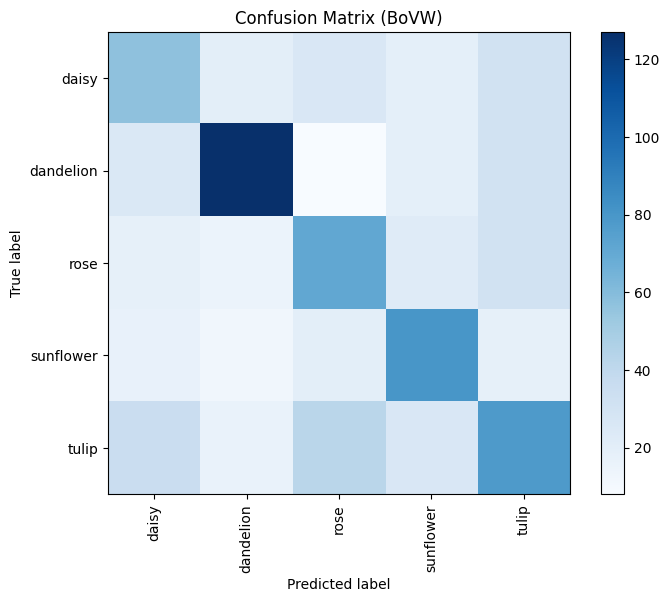

In [35]:
y_pred = knn.predict(X_test)
evaluate_model_plot_confusion_matrix(y_test, y_pred, classes, title_suffix="(BoVW)")


In [ ]:
#Pooling using means,max,min and combined

# 1)Preprocess and Extract descriptors for all images
for img in images:
    gray = preprocess_image(img, IMAGE_MAX_SIZE)
    kp, desc = sift.detectAndCompute(gray, None)

    if desc is None or len(desc) == 0:
        # No keypoints -> zero vector
        mean_pool = np.zeros(128)
        max_pool = np.zeros(128)
        min_pool = np.zeros(128)
    else:
        mean_pool = np.mean(desc, axis=0)
        max_pool = np.max(desc, axis=0)
        min_pool = np.min(desc, axis=0)

    # Combine pools (Mean + Max + Min)
    pooled = np.concatenate([mean_pool, max_pool, min_pool])
    max_pools.append(max_pool)
    mean_pools.append(mean_pool)
    min_pools.append(min_pool)

    features.append(pooled)
features = np.array(features, dtype=np.float32)
print("Feature matrix shape:", features.shape)

Feature matrix shape: (4317, 384)


In [14]:
# Normalize features 
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [15]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, labels, test_size=TEST_SIZE, stratify=labels, random_state=RANDOM_STATE
)

In [16]:
# KNN classifier
knn = KNeighborsClassifier(n_neighbors=KNN_NEIGHBORS, metric='euclidean')
knn.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'euclidean'
,metric_params,None
,n_jobs,None


KNN Accuracy (max+min+mean combined): 0.4780
              precision    recall  f1-score   support

       daisy       0.38      0.37      0.37       153
   dandelion       0.67      0.60      0.64       210
        rose       0.43      0.45      0.44       157
   sunflower       0.48      0.54      0.51       147
       tulip       0.41      0.40      0.40       197

    accuracy                           0.48       864
   macro avg       0.47      0.47      0.47       864
weighted avg       0.48      0.48      0.48       864



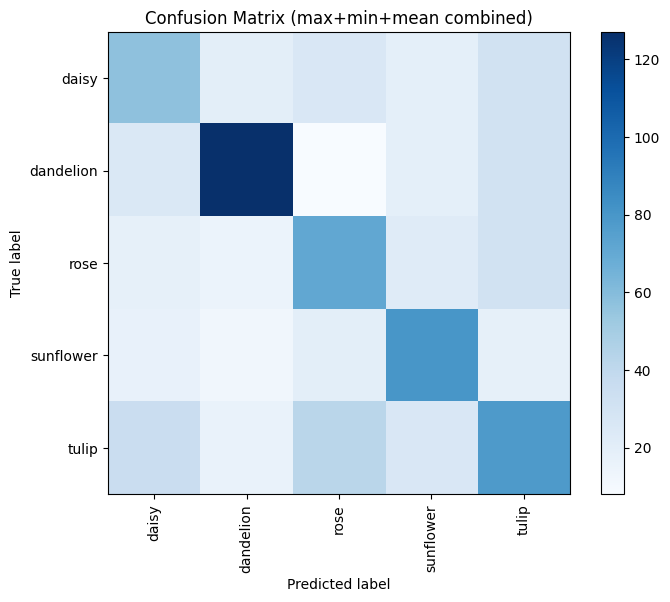

In [37]:
# Evaluate
y_pred = knn.predict(X_test)
evaluate_model_plot_confusion_matrix(y_test, y_pred, classes, title_suffix="(max+min+mean combined)")

Feature matrix shape: (4317, 128)
KNN Accuracy (Max pooling): 0.3947
              precision    recall  f1-score   support

       daisy       0.32      0.31      0.32       153
   dandelion       0.45      0.74      0.56       210
        rose       0.38      0.27      0.32       157
   sunflower       0.36      0.29      0.32       147
       tulip       0.38      0.27      0.31       197

    accuracy                           0.39       864
   macro avg       0.38      0.38      0.37       864
weighted avg       0.38      0.39      0.38       864



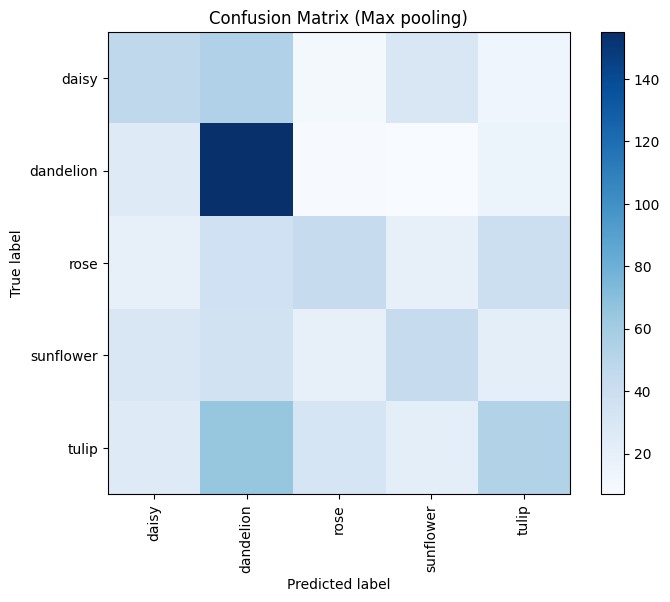

In [38]:
# using max pooling only
features = np.array(max_pools, dtype=np.float32)
print("Feature matrix shape:", features.shape)

# Normalize features (optional but helps distance metrics)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, labels, test_size=TEST_SIZE, stratify=labels, random_state=RANDOM_STATE
)

# KNN classifier
knn = KNeighborsClassifier(n_neighbors=KNN_NEIGHBORS, metric='euclidean')
knn.fit(X_train, y_train)

# Evaluate
y_pred = knn.predict(X_test)
evaluate_model_plot_confusion_matrix(y_test, y_pred, classes, title_suffix="(Max pooling)")

Feature matrix shape: (4317, 128)
KNN Accuracy (Min pooling): 0.2060
              precision    recall  f1-score   support

       daisy       0.17      0.24      0.20       153
   dandelion       0.25      0.31      0.28       210
        rose       0.20      0.17      0.18       157
   sunflower       0.17      0.16      0.17       147
       tulip       0.22      0.13      0.17       197

    accuracy                           0.21       864
   macro avg       0.20      0.20      0.20       864
weighted avg       0.21      0.21      0.20       864



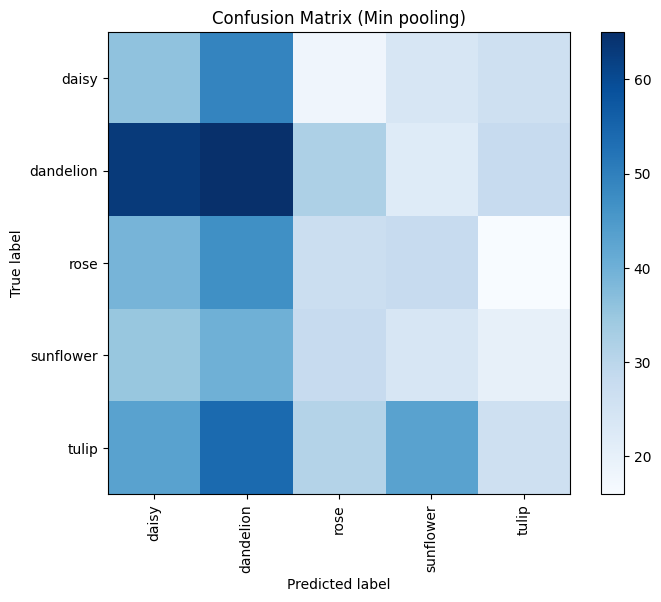

In [39]:
# using min pooling only
features = np.array(min_pools, dtype=np.float32)
print("Feature matrix shape:", features.shape)

# Normalize features 
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, labels, test_size=TEST_SIZE, stratify=labels, random_state=RANDOM_STATE
)

# KNN classifier
knn = KNeighborsClassifier(n_neighbors=KNN_NEIGHBORS, metric='euclidean')
knn.fit(X_train, y_train)

# Evaluate
y_pred = knn.predict(X_test)
evaluate_model_plot_confusion_matrix(y_test, y_pred, classes, title_suffix="(Min pooling)")

Feature matrix shape: (4317, 128)
KNN Accuracy (Mean pooling): 0.4780
              precision    recall  f1-score   support

       daisy       0.38      0.37      0.37       153
   dandelion       0.67      0.60      0.64       210
        rose       0.43      0.45      0.44       157
   sunflower       0.48      0.54      0.51       147
       tulip       0.41      0.40      0.40       197

    accuracy                           0.48       864
   macro avg       0.47      0.47      0.47       864
weighted avg       0.48      0.48      0.48       864



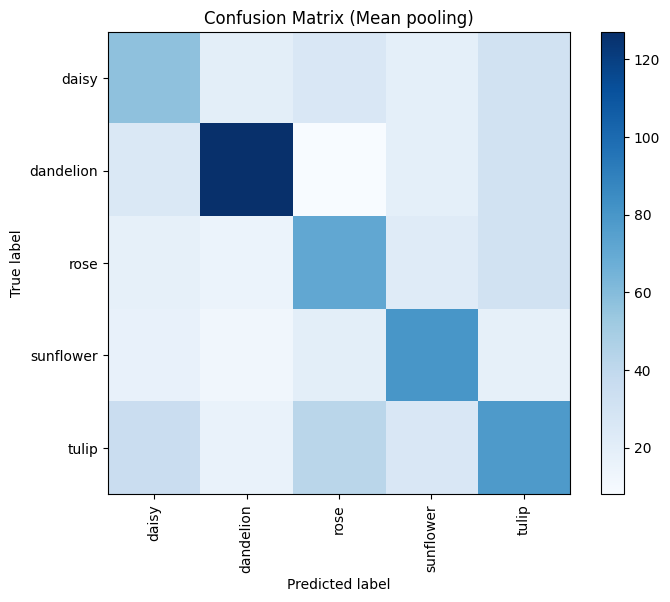

In [ ]:
# using mean pooling only
features = np.array(mean_pools, dtype=np.float32)
print("Feature matrix shape:", features.shape)

# Normalize features 
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, labels, test_size=TEST_SIZE, stratify=labels, random_state=RANDOM_STATE
)

# KNN classifier
knn = KNeighborsClassifier(n_neighbors=KNN_NEIGHBORS, metric='euclidean')
knn.fit(X_train, y_train)

# Evaluate
y_pred = knn.predict(X_test)
evaluate_model_plot_confusion_matrix(y_test, y_pred, classes, title_suffix="(Mean pooling)")